# 1、Introduction

This challenge comes from [#WOW2023 | Week 9 | A tricky filter](https://workout-wednesday.com/2023w09tab/). Its task mainly focuses on the interactivity of a bar chart.

I'll use `panel` for interactivity design, and `matplotlib` for the bar chart plotting. Without further ado, let's do it!

First import some compulsory libraries for the data manipulation and visualization design.

In [2]:
# For data manipulation
import pandas as pd

# For data visualization
# According https://panel.holoviz.org/reference/panes/Matplotlib.html, we should use 
# the matplotlib.figure api instead of matplotlib.pyplot api with panel
import matplotlib.figure as mfig

# For interactivity
import panel as pn
pn.extension('ipywidgets')

In [4]:
data_file = "./datasets/Superstore 2022.4.csv"
sale_data = pd.read_csv(data_file, index_col=0)
sale_data.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,State/Province,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Row ID,,,,,,,,,,,,,,,,,,,,
1,US-2019-103800,03/01/2019,07/01/2019,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,Texas,77095,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512
2,US-2019-112326,04/01/2019,08/01/2019,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540,2,0.8,-5.4870
3,US-2019-112326,04/01/2019,08/01/2019,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717
4,US-2019-112326,04/01/2019,08/01/2019,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748
5,US-2019-141817,05/01/2019,12/01/2019,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,Pennsylvania,19143,East,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536,3,0.2,4.8840


In [51]:
# Select the sales data from the State of Ohio
Ohio_data = sale_data.query("`State/Province` == 'Ohio'").loc[:, ["City", "Sales"]]
sales_Ohio = Ohio_data.groupby(by="City").sum()

key_cities = ['Cincinnati', 'Akron', 'Toledo', 'Cleveland', 'Columbus']
key_cities_data = sales_Ohio.loc[key_cities, :]

other_cities = [city for city in sales_Ohio.index if city not in key_cities]
other_cities_data = sales_Ohio.loc[other_cities, :]

key_cities_data

,Sales
City,
Cincinnati,1611.976
Akron,2729.986
Toledo,4466.053
Cleveland,6346.185
Columbus,15900.793


Matplotlib(Figure, height=504, width=720)
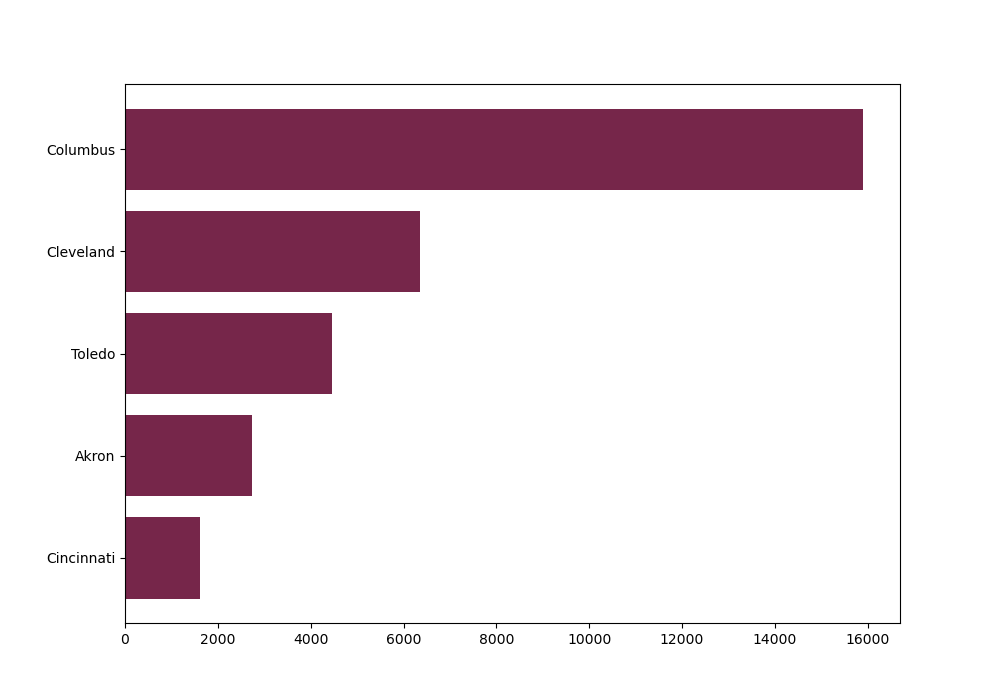

In [52]:
px = 1 / plt.rcParams['figure.dpi']
fig = mfig.Figure(figsize=(1000*px, 700*px))
ax = fig.subplots()

bar = ax.barh(y=key_cities_data.index, width=key_cities_data["Sales"], color=color)

pn.pane.Matplotlib(fig)

In [86]:
color = '#76264A'
title = pn.pane.HTML("<h3><b># WOW2023 Week 9: A tricky filter</b></h3>" + 
                     "Can you allow users to filter out any city except for " +
                     f"a select few <span style='color:{color};font-weight:bold'>Key Cities</span>?",
                    width=500)
filter_box = pn.Row('Filter Cities',
                    pn.widgets.CheckBoxGroup(value=[], options=list(other_cities_data.index), 
                                             inline=False),
                    height=50, scroll=True
                   )

sort_box = pn.Row("Sort By", 
                  pn.widgets.Select(options=['Key Cities', 'Sales'], value='Key Cities'),
                  align=("center", "center"),
                 )

pn.Row(title, pn.Column(filter_box, sort_box), align="start", width=1000)

Row(width=1000)
    [0] HTML(str, width=500)
    [1] Column
        [0] Row(height=50, scroll=True)
            [0] Markdown(str)
            [1] CheckBoxGroup(options=['Bowling Green', ...])
        [1] Row(align=('center', 'center'))
            [0] Markdown(str)
            [1] Select(options=['Key Cities', 'Sales'], value='Key Cities')

# filter_box[1].value